# Cài đặt PySpark

In [ ]:
!pip install pyspark

# Chuyển đổi file excel sang csv

In [ ]:
!pip install gdown pyspark

In [ ]:
import gdown
from pyspark.sql import SparkSession
from pyspark.sql import Row
import numpy as np
import pandas as pd
from pyspark.sql import DataFrame

In [ ]:
spark = SparkSession.builder.appName("Data_Supervised_ML").getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Phân tích dữ liệu cơ bản

In [ ]:
from pyspark.sql import SparkSession
from datetime import datetime
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType

spark = SparkSession.builder.appName("Optimized RDD Data Preprocessing").getOrCreate()

# Load the CSV file
df = spark.read.csv('/content/drive/MyDrive/CỦA TÔI/NHOM2_CK/OnlineRetail.csv', header=True, inferSchema=True)

# Convert DataFrame to RDD
rdd = df.rdd

# Filter out rows where InvoiceNo starts with "C"
filtered_rdd = rdd.filter(lambda row: not row.InvoiceNo.startswith("C"))

# Parse the date correctly
def parse_date(row):
    try:
        date = datetime.strptime(row['InvoiceDate'], '%d-%m-%Y %H:%M')
    except:
        date = None
    return (row['InvoiceNo'], row['StockCode'], row['Description'], row['Quantity'],
            row['InvoiceDate'], row['UnitPrice'], row['CustomerID'], row['Country'], date)

# Map the RDD to include the parsed date
rdd_with_date = filtered_rdd.map(parse_date)

# Define the schema
schema = StructType([
    StructField("InvoiceNo", StringType(), True),
    StructField("StockCode", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Quantity", IntegerType(), True),
    StructField("InvoiceDate", StringType(), True),
    StructField("UnitPrice", DoubleType(), True),
    StructField("CustomerID", StringType(), True),
    StructField("Country", StringType(), True),
    StructField("date", TimestampType(), True)
])

# Create DataFrame from the RDD with the correct schema
df_processed = spark.createDataFrame(rdd_with_date, schema)
df_processed.show(5, truncate=False)


+---------+---------+-----------------------------------+--------+----------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate     |UnitPrice|CustomerID|Country       |date               |
+---------+---------+-----------------------------------+--------+----------------+---------+----------+--------------+-------------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |01-12-2010 08:26|2.55     |17850     |United Kingdom|2010-12-01 08:26:00|
|536365   |71053    |WHITE METAL LANTERN                |6       |01-12-2010 08:26|3.39     |17850     |United Kingdom|2010-12-01 08:26:00|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |01-12-2010 08:26|2.75     |17850     |United Kingdom|2010-12-01 08:26:00|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |01-12-2010 08:26|3.39     |17850     |United Kingdom|2010-12-01 08:26:00|
|536365   |84029E   

In [ ]:
from pyspark.sql import functions as F

invoice_totals = df_processed.withColumn("TotalCost", F.col("Quantity") * F.col("UnitPrice")) \
                             .groupBy("InvoiceNo") \
                             .agg(F.sum("TotalCost").alias("TotalCost"))
revenue_per_customer = df_processed.withColumn("Revenue", F.col("Quantity") * F.col("UnitPrice")) \
                                   .groupBy("CustomerID") \
                                   .agg(F.sum("Revenue").alias("TotalRevenue"))

revenue_per_country = df_processed.withColumn("Revenue", F.col("Quantity") * F.col("UnitPrice")) \
                                  .groupBy("Country") \
                                  .agg(F.sum("Revenue").alias("TotalRevenue"))

orders_per_day = df_processed.filter(F.col("date").isNotNull()) \
                             .withColumn("DayOfWeek", F.date_format(F.col("date"), "EEEE")) \
                             .groupBy("DayOfWeek") \
                             .count() \
                             .orderBy("count", ascending=False)

average_order_value = invoice_totals.agg(F.avg("TotalCost").alias("AverageOrderValue"))

top_selling_products = df_processed.groupBy("StockCode", "Description") \
                                   .agg(F.sum("Quantity").alias("TotalQuantity")) \
                                   .orderBy("TotalQuantity", ascending=False) \
                                   .limit(10)

print("Tổng chi phí của từng hóa đơn:")
invoice_totals.show()

print("Doanh thu theo khách hàng:")
revenue_per_customer.show()

print("Doanh thu theo quốc gia:")
revenue_per_country.show()

print("Số lượng đơn hàng theo ngày trong tuần:")
orders_per_day.show()

print("Giá trị trung bình của đơn hàng:")
average_order_value.show()

print("Các sản phẩm bán chạy nhất:")
top_selling_products.show()

Tổng chi phí của từng hóa đơn:
+---------+------------------+
|InvoiceNo|         TotalCost|
+---------+------------------+
|   536596|             38.09|
|   536938|1680.8799999999999|
|   537252|26.349999999999998|
|   537691|            310.57|
|   538041|               0.0|
|   538184|458.91999999999985|
|   538517|320.28000000000003|
|   538879| 338.9799999999999|
|   539275|403.79999999999995|
|   539630|             751.0|
|   540499|             365.2|
|   540540|            169.35|
|   540976| 919.9799999999998|
|   541432|            158.95|
|   541518|2919.5099999999998|
|   541783|            728.16|
|   542026|            169.65|
|   542375|             178.1|
|   543641|197.94000000000003|
|   544303|161.95000000000002|
+---------+------------------+
only showing top 20 rows

Doanh thu theo khách hàng:
+----------+------------------+
|CustomerID|      TotalRevenue|
+----------+------------------+
|     16250|389.44000000000005|
|     15574| 702.2500000000001|
|     15555|

In [ ]:
df_processed.count()

532621

In [ ]:
df_processed.select('CustomerID').distinct().count()

4340

In [ ]:
from pyspark.sql.functions import countDistinct, desc
df_processed.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()

+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         3921|
|        Germany|           94|
|         France|           87|
|          Spain|           30|
|        Belgium|           25|
|    Switzerland|           21|
|       Portugal|           19|
|          Italy|           14|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|        Denmark|            9|
|Channel Islands|            9|
|      Australia|            9|
|    Netherlands|            9|
|         Sweden|            8|
|         Cyprus|            8|
|          Japan|            8|
|         Poland|            6|
|         Greece|            4|
+---------------+-------------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import min, max
date_range = df_processed.select(min("date").alias("EarliestOrderDate"), max("date").alias("LatestOrderDate"))
date_range.show()


+-------------------+-------------------+
|  EarliestOrderDate|    LatestOrderDate|
+-------------------+-------------------+
|2010-12-01 08:26:00|2011-12-09 12:50:00|
+-------------------+-------------------+



# Data preprocessing

## Recency

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import to_timestamp, lit, col, max


# Tạo cột from_date với giá trị mặc định
df = df_processed.withColumn("from_date", lit("2010-12-01 08:26:00"))

# Chuyển đổi from_date sang định dạng timestamp
df = df.withColumn("from_date", to_timestamp("from_date", "yyyy-MM-dd HH:mm:ss"))


df2= df.withColumn('from_date',to_timestamp(col('from_date'))).withColumn('recency',col("date").cast("long") - col('from_date').cast("long"))

df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')

df2.select("CustomerID", "date", "recency").show()

+----------+-------------------+-------+
|CustomerID|               date|recency|
+----------+-------------------+-------+
|     12797|2010-12-09 10:55:00| 700140|
|     12797|2010-12-09 10:55:00| 700140|
|     12797|2010-12-09 10:55:00| 700140|
|     12797|2010-12-09 10:55:00| 700140|
|     12797|2010-12-09 10:55:00| 700140|
|     12797|2010-12-09 10:55:00| 700140|
|     12797|2010-12-09 10:55:00| 700140|
|     12797|2010-12-09 10:55:00| 700140|
|     12797|2010-12-09 10:55:00| 700140|
|     12797|2010-12-09 10:55:00| 700140|
|     12797|2010-12-09 10:55:00| 700140|
|     12797|2010-12-09 10:55:00| 700140|
|     12797|2010-12-09 10:55:00| 700140|
|     13716|2011-03-15 13:49:00|9004980|
|     13716|2011-03-15 13:49:00|9004980|
|     13716|2011-03-15 13:49:00|9004980|
|     13716|2011-03-15 13:49:00|9004980|
|     13716|2011-03-15 13:49:00|9004980|
|     13716|2011-03-15 13:49:00|9004980|
|     13716|2011-03-15 13:49:00|9004980|
+----------+-------------------+-------+
only showing top

In [ ]:
df2.show(5)

+-------+---------+---------+--------------------+--------+----------------+---------+----------+--------+-------------------+-------------------+
|recency|InvoiceNo|StockCode|         Description|Quantity|     InvoiceDate|UnitPrice|CustomerID| Country|               date|          from_date|
+-------+---------+---------+--------------------+--------+----------------+---------+----------+--------+-------------------+-------------------+
| 700140|   537915|    21891|TRADITIONAL WOODE...|      12|09-12-2010 10:55|     1.25|     12797|Portugal|2010-12-09 10:55:00|2010-12-01 08:26:00|
| 700140|   537915|    21892|TRADITIONAL WOODE...|      12|09-12-2010 10:55|     1.25|     12797|Portugal|2010-12-09 10:55:00|2010-12-01 08:26:00|
| 700140|   537915|    22623|BOX OF VINTAGE JI...|       3|09-12-2010 10:55|     4.95|     12797|Portugal|2010-12-09 10:55:00|2010-12-01 08:26:00|
| 700140|   537915|    22622|BOX OF VINTAGE AL...|       2|09-12-2010 10:55|     9.95|     12797|Portugal|2010-12-09 1

## Frequency

In [ ]:
from pyspark.sql.functions import countDistinct
# Step 4: Calculate frequency for each customer based on unique InvoiceNo counts
df_frequency = df_processed.groupBy("CustomerID").agg(countDistinct("InvoiceNo").alias("frequency"))
# Show the frequency DataFrame
df_frequency.show()


+----------+---------+
|CustomerID|frequency|
+----------+---------+
|     15555|       16|
|     15574|        4|
|     14157|        2|
|     17686|        7|
|     13610|        7|
|     13865|        4|
|     16250|        2|
|     17714|        1|
|     13282|        3|
|     15271|       15|
|     16320|        2|
|     12394|        2|
|     13192|        2|
|     15634|        1|
|     14204|        1|
|     17427|        1|
|     18130|        3|
|     15269|        1|
|     16504|        1|
|     12847|        1|
+----------+---------+
only showing top 20 rows



## Monetary Value

In [ ]:
from pyspark.sql.functions import col, sum as F_sum

# Calculate the TotalCost for each row and aggregate by CustomerID to get total monetary value
df_monetary = df_processed.withColumn("TotalCost", col("Quantity") * col("UnitPrice")) \
                          .groupBy("CustomerID") \
                          .agg(F_sum("TotalCost").alias("monetary_value"))

# Display the monetary value for each customer
df_monetary.show()


+----------+------------------+
|CustomerID|    monetary_value|
+----------+------------------+
|     16250|389.44000000000005|
|     15574| 702.2500000000001|
|     15555| 4805.169999999994|
|     15271|2507.0699999999997|
|     17714|             153.0|
|     17686| 5739.460000000005|
|     13865|501.56000000000006|
|     14157| 432.8800000000001|
|     13610|1131.8799999999999|
|     13772|           1132.13|
|     13282|1132.1399999999999|
|     12394|           1272.48|
|     16320|           1038.46|
|     13192|            911.94|
|     17757| 5605.289999999997|
|     17551|            306.84|
|     13187|236.01999999999995|
|     16549| 4154.640000000004|
|     12637| 6021.900000000003|
|     15052|            215.78|
+----------+------------------+
only showing top 20 rows



## Kiểm tra dữ liệu cho mô hình học máy


In [ ]:
# Join recency, frequency, and monetary data on CustomerID
df_rfm = df2.join(df_frequency, on="CustomerID", how="inner") \
                   .join(df_monetary, on="CustomerID", how="inner")


In [ ]:
# Show Recency, Frequency, and Monetary Value DataFrame
print("RFM Metrics per Customer:")

RFM Metrics per Customer:


In [ ]:
final_df = df_rfm.select(['recency','frequency','monetary_value','CustomerID']).distinct()
final_df.show()

+--------+---------+------------------+----------+
| recency|frequency|    monetary_value|CustomerID|
+--------+---------+------------------+----------+
| 9700860|        2|389.44000000000005|     16250|
|16947300|        4| 702.2500000000001|     15574|
|31218780|       16| 4805.169999999994|     15555|
|31643100|       15|2507.0699999999997|     15271|
| 4586760|        1|             153.0|     17714|
|31648380|        7| 5739.460000000005|     17686|
|27234300|        4|501.56000000000006|     13865|
|30596760|        2| 432.8800000000001|     14157|
|31216320|        7|1131.8799999999999|     13610|
|29387820|        3|           1132.13|     13772|
|30697620|        3|1132.1399999999999|     13282|
|26782920|        2|           1272.48|     12394|
|17391540|        2|           1038.46|     16320|
|24040020|        2|            911.94|     13192|
|32166300|       30| 5605.289999999997|     17757|
|30702480|       30| 5605.289999999997|     17757|
| 1230360|        1|           

# Chuẩn hóa dữ liệu

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble=VectorAssembler(inputCols=[
    'recency','frequency','monetary_value'
], outputCol='features')

assembled_data=assemble.transform(final_df)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)



In [ ]:
data_scale_output.select('standardized').show(2,truncate=False)

+------------------------------------------------------------+
|standardized                                                |
+------------------------------------------------------------+
|[2.003833479365148,0.12386277091331907,0.07758679113935381] |
|[0.528481275942952,0.061931385456659535,0.01143113749621664]|
+------------------------------------------------------------+
only showing top 2 rows



# Xây dựng mô hình học máy K-means

## Tìm số cụm K

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np
from tqdm import tqdm


cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in tqdm(range(2,10)):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

100%|██████████| 8/8 [48:11<00:00, 361.42s/it]


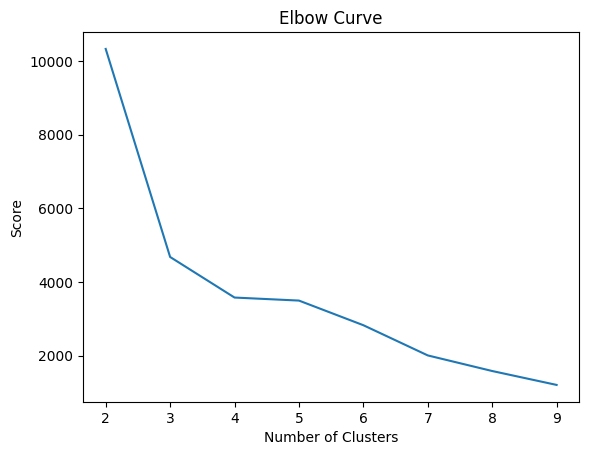

In [ ]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

## Training K-means với k=4

In [ ]:
kmeans_algo=KMeans(featuresCol='standardized', k=4)
kmeans_fit=kmeans_algo.fit(data_scale_output)

## Tiến hành dự đoán cụm

In [ ]:
preds=kmeans_fit.transform(data_scale_output)
preds.show(5)

+--------+---------+------------------+----------+--------------------+--------------------+----------+
| recency|frequency|    monetary_value|CustomerID|            features|        standardized|prediction|
+--------+---------+------------------+----------+--------------------+--------------------+----------+
| 9700860|        2|389.44000000000005|     16250|[9700860.0,2.0,38...|[1.11772206754745...|         0|
|16947300|        4| 702.2500000000001|     15574|[1.69473E7,4.0,70...|[1.95264865128936...|         0|
|31218780|       16| 4805.169999999994|     15555|[3.121878E7,16.0,...|[3.59699236231725...|         3|
|31643100|       15|2507.0699999999997|     15271|[3.16431E7,15.0,2...|[3.64588203062519...|         3|
| 4586760|        1|             153.0|     17714|[4586760.0,1.0,15...|[0.52848127594295...|         0|
+--------+---------+------------------+----------+--------------------+--------------------+----------+
only showing top 5 rows



# Trực quan hóa kết quả phân cụm

<ipython-input-25-59ccef2e5080>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='prediction', y=str(i), data=avg_df, palette='viridis')


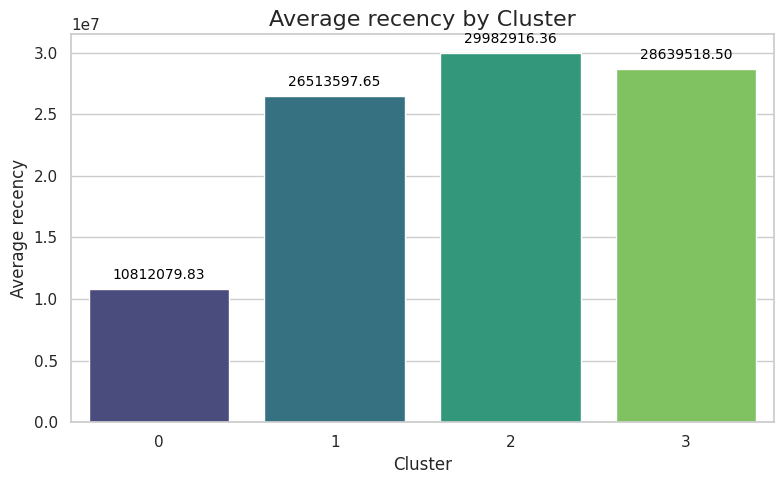

<ipython-input-25-59ccef2e5080>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='prediction', y=str(i), data=avg_df, palette='viridis')


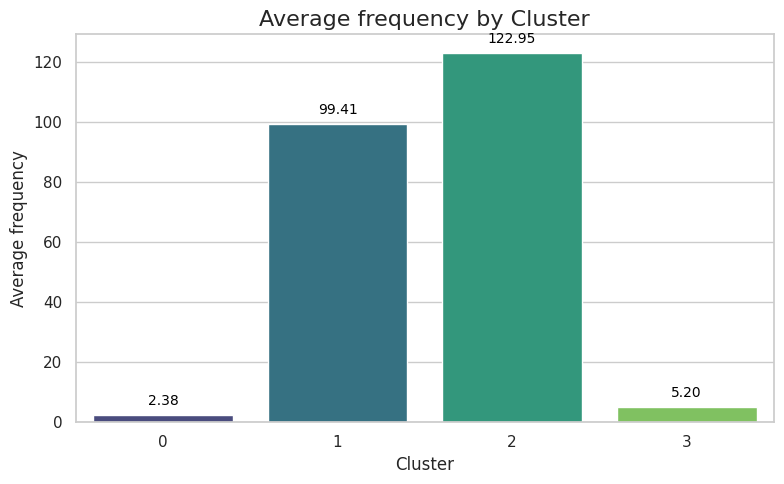

<ipython-input-25-59ccef2e5080>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='prediction', y=str(i), data=avg_df, palette='viridis')


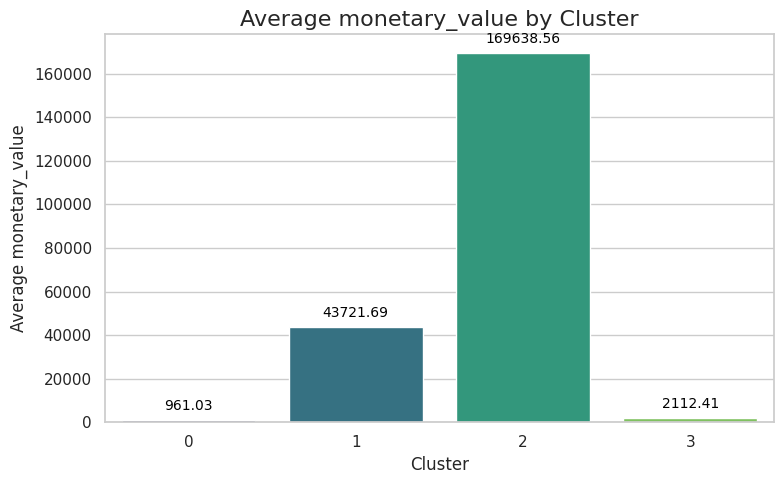

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency', 'frequency', 'monetary_value', 'prediction')
df_viz = df_viz.toPandas()

avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list_value = ['recency', 'frequency', 'monetary_value']

sns.set(style="whitegrid")

for i in list_value:
    plt.figure(figsize=(8, 5))
    bar_plot = sns.barplot(x='prediction', y=str(i), data=avg_df, palette='viridis')

    plt.title(f'Average {i} by Cluster', fontsize=16)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel(f'Average {i}', fontsize=12)

    for p in bar_plot.patches:
        bar_plot.annotate(format(p.get_height(), '.2f'),
                          (p.get_x() + p.get_width() / 2., p.get_height()),
                          ha='center', va='bottom',
                          fontsize=10, color='black', rotation=0,
                          xytext=(0, 5),
                          textcoords='offset points')

    plt.tight_layout()
    plt.show()


#RCM

In [ ]:
df = spark.read.csv('/content/drive/MyDrive/CỦA TÔI/NHOM2_CK/OnlineRetail.csv', header=True, inferSchema=True)


In [ ]:
df.show(5)

+---------+---------+--------------------+--------+----------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|01-12-2010 08:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|01-12-2010 08:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|01-12-2010 08:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|01-12-2010 08:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|01-12-2010 08:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType

spark = SparkSession.builder.appName("ALS Model Training").getOrCreate()

df_cleaned = df.dropna(subset=["CustomerID", "StockCode", "Quantity"])

als_data = df_cleaned.filter(
                          (F.col("Quantity") > 0) &
                          F.col("CustomerID").isNotNull() &
                          F.col("StockCode").isNotNull()
                      ) \
                      .select(
                          F.col("CustomerID").cast(IntegerType()).alias("user_id"),
                          F.col("StockCode").cast(IntegerType()).alias("item_id"),
                          F.col("Quantity").cast(IntegerType()).alias("rating")
                      ) \
                      .dropna(subset=["user_id", "item_id"])  # Loại bỏ các hàng có giá trị null trong user_id và item_id


als = ALS(userCol="user_id", itemCol="item_id", ratingCol="rating", coldStartStrategy="drop", nonnegative=True)

param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [10, 20, 30]) \
    .addGrid(als.maxIter, [5, 10]) \
    .addGrid(als.regParam, [0.01, 0.1, 0.2]) \
    .build()

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

crossval = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)

train_data, test_data = als_data.randomSplit([0.7, 0.3])

cv_model = crossval.fit(train_data)


In [ ]:
best_model = cv_model.bestModel

predictions = best_model.transform(test_data)
rmse = evaluator.evaluate(predictions)
print(f"Best Model's RMSE on test data: {rmse}")

print(f"Best rank: {best_model.rank}")
print(f"Best maxIter: {best_model._java_obj.parent().getMaxIter()}")
print(f"Best regParam: {best_model._java_obj.parent().getRegParam()}")

best_model.userFactors.show()
best_model.itemFactors.show()

best_model.recommendForAllUsers(3).show()


Best Model's RMSE on test data: 33.66984784435793
Best rank: 30
Best maxIter: 10
Best regParam: 0.01
+-----+--------------------+
|   id|            features|
+-----+--------------------+
|12350|[0.0, 0.084478065...|
|12360|[0.19722603, 0.09...|
|12370|[0.0, 0.0, 0.0914...|
|12380|[0.0, 0.0, 0.4529...|
|12390|[0.08485217, 0.24...|
|12410|[0.0, 0.0, 0.0, 0...|
|12420|[0.0, 0.0, 0.0, 0...|
|12430|[0.0138090905, 0....|
|12450|[0.0, 0.33238924,...|
|12480|[0.0, 0.0, 0.0, 0...|
|12490|[0.17198715, 0.05...|
|12500|[1.8712943, 1.809...|
|12510|[0.0, 0.057024408...|
|12520|[0.0, 0.060895886...|
|12530|[0.0, 0.0, 0.1716...|
|12540|[0.089470744, 0.2...|
|12550|[0.0, 0.0, 9.9879...|
|12560|[0.0, 0.037852038...|
|12580|[0.1687991, 0.025...|
|12590|[0.0, 3.7975507, ...|
+-----+--------------------+
only showing top 20 rows

+-----+--------------------+
|   id|            features|
+-----+--------------------+
|10080|[0.2244709, 0.0, ...|
|10120|[17.971283, 0.800...|
|15030|[0.0, 0.0, 0.0, 0...|
|16

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
cv_model.write().overwrite().save("/content/drive/MyDrive/CỦA TÔI/NHOM2_CK/cv_model")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("RecommendationSystem").getOrCreate()

loaded_cv_model = CrossValidatorModel.load("/content/drive/MyDrive/CỦA TÔI/NHOM2_CK/cv_model")
best_model_loaded = loaded_cv_model.bestModel

user_recommendations_expanded = best_model_loaded.recommendForAllUsers(10) \
    .withColumn("item_id", F.expr("explode(recommendations.item_id)")) \
    .withColumn("rating", F.expr("explode(recommendations.rating)")) \
    .select("user_id", "item_id", "rating")

user_recommendations_expanded.createOrReplaceTempView("user_recommendation_table")

def get_recommendations_for_user(user_id: int):
    query = f"SELECT * FROM user_recommendation_table WHERE user_id = {user_id}"
    spark.sql(query).show()

get_recommendations_for_user(12346)


+-------+-------+---------+
|user_id|item_id|   rating|
+-------+-------+---------+
|  12346|  18007|662890.44|
|  12346|  18007|660091.56|
|  12346|  18007|494945.53|
|  12346|  18007|309702.62|
|  12346|  18007|199254.52|
|  12346|  18007|192480.92|
|  12346|  18007|190589.19|
|  12346|  18007|179540.45|
|  12346|  18007|171282.61|
|  12346|  18007|166970.56|
|  12346|  84568|662890.44|
|  12346|  84568|660091.56|
|  12346|  84568|494945.53|
|  12346|  84568|309702.62|
|  12346|  84568|199254.52|
|  12346|  84568|192480.92|
|  12346|  84568|190589.19|
|  12346|  84568|179540.45|
|  12346|  84568|171282.61|
|  12346|  84568|166970.56|
+-------+-------+---------+
only showing top 20 rows

